In [160]:
!pip install qutip
!pip install stable_baselines

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


Total run time:   2.28s
0


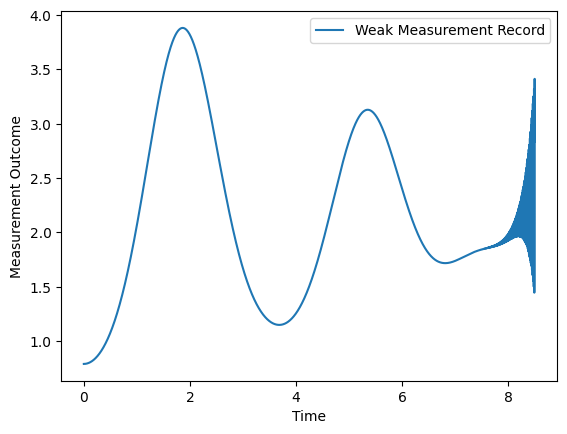

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

N = 60
x_max = 5.0
x = np.linspace(-x_max, x_max, N)

x_op = position(N)
p_op = momentum(N)

kinetic_energy = 0.5*p_op**2

h = 5.0
a = 0.0
b = 3.0
V_x = (h/(b**4))*((x_op-a)**2-b**2)**2

H = kinetic_energy + V_x
H = Qobj(H)

alpha = 1.0
psi0 = coherent(N, alpha)

T = 8.5
times = np.linspace(0, T, 10001)

Tau = 0.1

M = np.sqrt(Tau) * x_op * x_op
#M = x_op*x_op

sme_result = smesolve(H, psi0, times, e_ops=[M], c_ops=[])
measurement_record = sme_result.expect[0]
print(len(sme_result.states))

plt.plot(times, measurement_record, label='Weak Measurement Record')
plt.xlabel('Time')
plt.ylabel('Measurement Outcome')
plt.legend()
plt.show()

In [159]:
import numpy as np
import gym
from gym import spaces
from qutip import *

class QuantumEnvironment(gym.Env):
    def __init__(self):
        super(QuantumEnvironment, self).__init__()
        self.N = 100  # Number of basis states
        self.alpha = 1.0

        self.x_op = position(self.N)
        self.p_op = momentum(self.N)

        self.h = 5.0
        self.a = 0.0
        self.b = 3.0
        self.At = 0.2

        self.V_x = np.diag((self.h/(self.b**4))*((x_op-self.a)**2-b**2)**2)
        self.KE = 0.5*p_op**2

        self.squeeze = self.At*(x_op*p_op+p_op*x_op)

        self.H0 = Qobj(self.KE+self.V_x+self.squeeze)
        self.M = np.sqrt(self.Tau)*x_op*x_op

        self.action_space = spaces.Box(low=-5.0, high=5.0, shape=(1,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,))
        self.state = coherent(N,self.alpha)

    def step(self, action):
        tlist = np.linspace(0, 0.01, 100)
        sme_result = smesolve(self.H0, self.state, tlist, [], e_ops=[self.M])
        self.state = sme_result.states[-1]
        observation = np.real(expect(self.M))
        reward = self.calculate_reward(observation)
        done = False

        return observation, reward, done, {}

    def reset(self):
        self.state = coherent(self.N, alpha=1.0)  # Change the initial state as needed
        return np.real(expect(self.x_op, self.state))

    def render(self, mode='human'):
        pass

    def close(self):
        pass

    def calculate_reward(self, observation):
        return -observation

# Create and test the environment
if __name__ == "__main__":
    env = QuantumEnvironment()
    obs = env.reset()
    total_reward = 0

    for _ in range(1000):
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        total_reward += reward

    print("Total Reward:", total_reward)
    env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: ignored

In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

from stable_baselines.common.env_checker import check_env
env = QuantumEnvironment()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

env = QuantumEnvironment()

obs = env.reset()
env.render()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())

GO_LEFT = 0
# Hardcoded best agent: always go left!
n_steps = 20
for step in range(n_steps):
  print("Step {}".format(step + 1))
  obs, reward, done, info = env.step(GO_LEFT)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render()
  if done:
    print("Goal reached!", "reward=", reward)
    break

from stable_baselines import DQN, PPO2, A2C, ACKTR
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = QuantumEnvironment(grid_size=10)
# wrap it
env = make_vec_env(lambda: env, n_envs=1)

# Train the agent
model = ACKTR('MlpPolicy', env, verbose=1).learn(5000)
# Test the trained agent
obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console')
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("done", "reward=", reward)
    break